<a href="https://colab.research.google.com/github/PaulRobertH/wine-ml-portfolio/blob/main/2_eda_and_correlations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/ML-Portfolio/data/merged_prepared_data.csv', index_col=0, parse_dates=True)

# Rename key columns for simplicity
df = df.rename(columns={
    'ECONOMICS_USCPI, M': 'US CPI',
    'ECONOMICS_USINTR, 1M': 'US Interest Rate',
    'TVC_DXY, 1M': 'Dollar Index (DXY)',
    'TVC_GOLD, 1M': 'Gold',
    'CME_MINI_ES1!, 1M (1)': 'S&P 500 Futures'
})

# Fill missing values
df = df.ffill().bfill()


In [ ]:
# Calculate 12-month wine return
df['Wine_ret'] = df['Liv-ex 100'].pct_change(12)

# Create lagged CPI features and compute correlations
cpi_lag_corrs = {}
for lag in [0, 3, 6, 12]:
    df[f'CPI_lag_{lag}'] = df['US CPI'].shift(lag)
    temp = df[['Wine_ret', f'CPI_lag_{lag}']].dropna()
    corr = temp.corr().iloc[0, 1]
    cpi_lag_corrs[f'CPI_lag_{lag}'] = corr

# Print results
print("Correlation of Wine Returns vs Lagged CPI:")
print(pd.Series(cpi_lag_corrs).sort_index())


Correlation of Wine Returns vs Lagged CPI:
CPI_lag_0    -0.027818
CPI_lag_12   -0.157003
CPI_lag_3    -0.064979
CPI_lag_6    -0.096684
dtype: float64


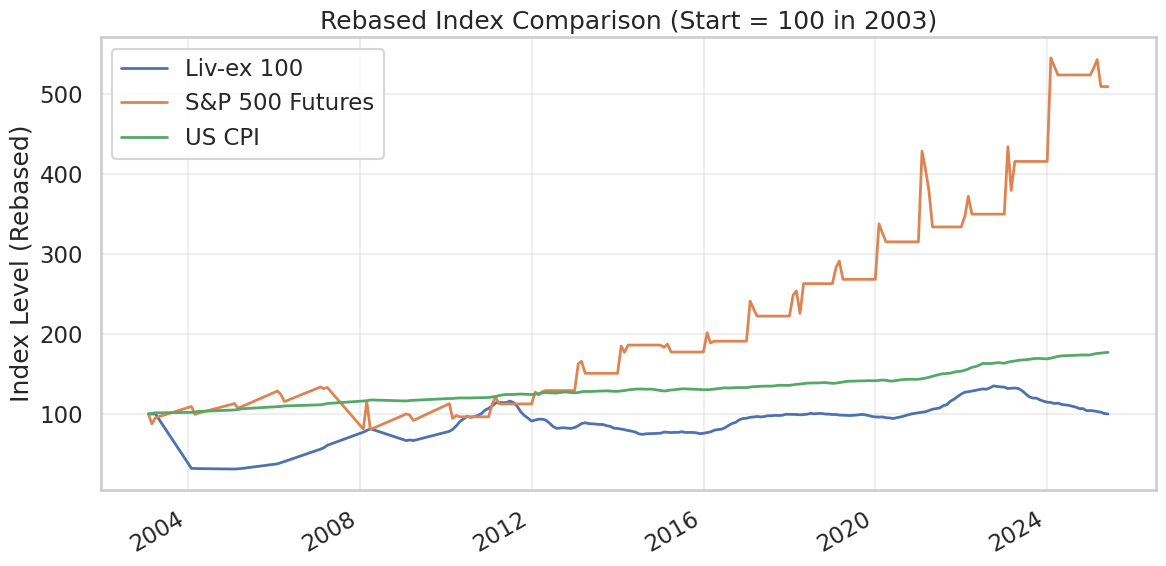

In [66]:
# Select columns and force start from 2003
rebased_assets = ['Liv-ex 100', 'S&P 500 Futures', 'Gold', 'US CPI']
rebased_cols = [col for col in rebased_assets if col in df.columns]

# Slice from 2003 onward and drop any NaNs
df_2003 = df[rebased_cols].loc['2003':].dropna()

# Rebase to 100 at 2003
rebased = df_2003 / df_2003.iloc[0] * 100

# Plot
rebased.plot(figsize=(12, 6), linewidth=2, title='Rebased Index Comparison (Start = 100 in 2003)')
plt.ylabel('Index Level (Rebased)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
# Tag inflation regimes based on 12M CPI change
df['Inflation Regime'] = np.where(df['US CPI'].pct_change(12) > 0.04, 'High CPI', 'Low CPI')
df[['US CPI', 'Inflation Regime']].tail(12)


,US CPI,Inflation Regime
2000-01-31,168.8,High CPI
2000-02-29,169.8,High CPI
2000-03-31,171.2,High CPI
2001-01-31,175.1,High CPI
2001-02-28,175.8,High CPI
2001-03-31,176.2,High CPI
2002-01-31,177.1,High CPI
2002-02-28,177.8,High CPI
2002-03-31,178.8,High CPI
2003-01-31,181.7,High CPI


In [82]:
df_infl = df[['Liv-ex 100', 'US CPI']].copy().dropna()

# Lagged features of inflation
for lag in [0, 3, 6, 12]:
    df_infl[f'CPI_lag_{lag}'] = df_infl['US CPI'].shift(lag)

# Target: future 12M wine return
df_infl['wine_12m_ret'] = df_infl['Liv-ex 100'].pct_change(12).shift(-12)

# Build model
features = [f'CPI_lag_{lag}' for lag in [0, 3, 6, 12]]
model_data = df_infl[features + ['wine_12m_ret']].dropna()
X = model_data[features]
y = model_data['wine_12m_ret']

# Train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

from sklearn.linear_model import LinearRegression
model = LinearRegression().fit(X_train, y_train)

# Output
print("Train R²:", model.score(X_train, y_train))
print("Test R²:", model.score(X_test, y_test))
print("Coefficients:")
for name, coef in zip(X.columns, model.coef_):
    print(f"{name}: {coef:.4f}")


Train R²: 0.13482945613838526
Test R²: -14.34706524455334
Coefficients:
CPI_lag_0: 0.0265
CPI_lag_3: 0.0160
CPI_lag_6: -0.0129
CPI_lag_12: -0.0256


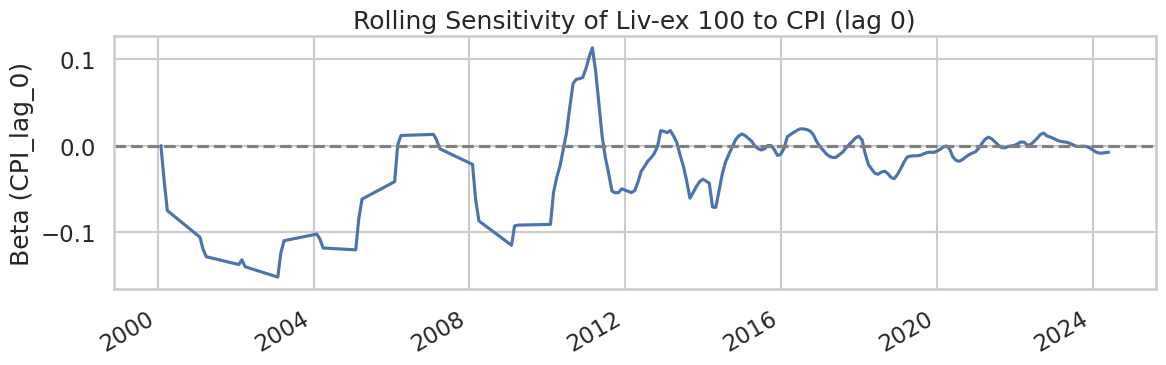

In [83]:
window = 36  # 3 years
rolling_betas = []

for i in range(window, len(X)):
    X_win = X.iloc[i-window:i]
    y_win = y.iloc[i-window:i]
    reg = LinearRegression().fit(X_win, y_win)
    rolling_betas.append(reg.coef_[0])  # e.g., beta for CPI_lag_0

# Plot rolling CPI_lag_0 sensitivity
pd.Series(rolling_betas, index=X.index[window:]).plot(
    title="Rolling Sensitivity of Liv-ex 100 to CPI (lag 0)", figsize=(12, 4))
plt.axhline(0, linestyle='--', color='gray')
plt.ylabel('Beta (CPI_lag_0)')
plt.grid(True)
plt.tight_layout()
plt.show()


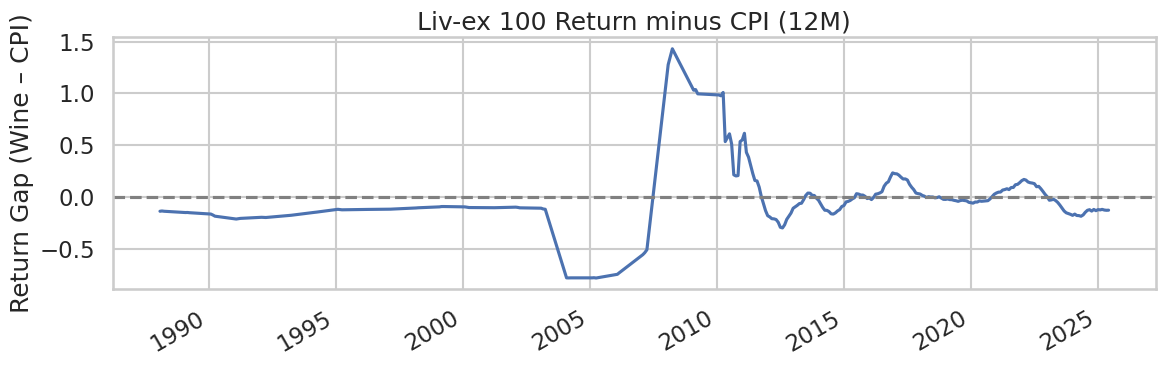

In [84]:
df_gap = df[['Liv-ex 100', 'US CPI']].copy().dropna()

# Calculate 12-month returns
df_gap['wine_ret_12m'] = df_gap['Liv-ex 100'].pct_change(12)
df_gap['cpi_ret_12m'] = df_gap['US CPI'].pct_change(12)

# Calculate the gap
df_gap['wine_minus_cpi'] = df_gap['wine_ret_12m'] - df_gap['cpi_ret_12m']

# Plot the gap
df_gap['wine_minus_cpi'].plot(figsize=(12, 4), title='Liv-ex 100 Return minus CPI (12M)')
plt.axhline(0, linestyle='--', color='gray')
plt.ylabel('Return Gap (Wine – CPI)')
plt.grid(True)
plt.tight_layout()
plt.show()


In [86]:
# Tag potential mean-reversion signals
df_gap['reversion_flag'] = (df_gap['wine_minus_cpi'] < -0.02).astype(int)

# Future wine return (next 12M) — what we want to predict
df_gap['wine_ret_next_12m'] = df_gap['Liv-ex 100'].pct_change(12).shift(-12)

# Drop NaNs
df_model = df_gap.dropna(subset=['wine_minus_cpi', 'wine_ret_next_12m'])


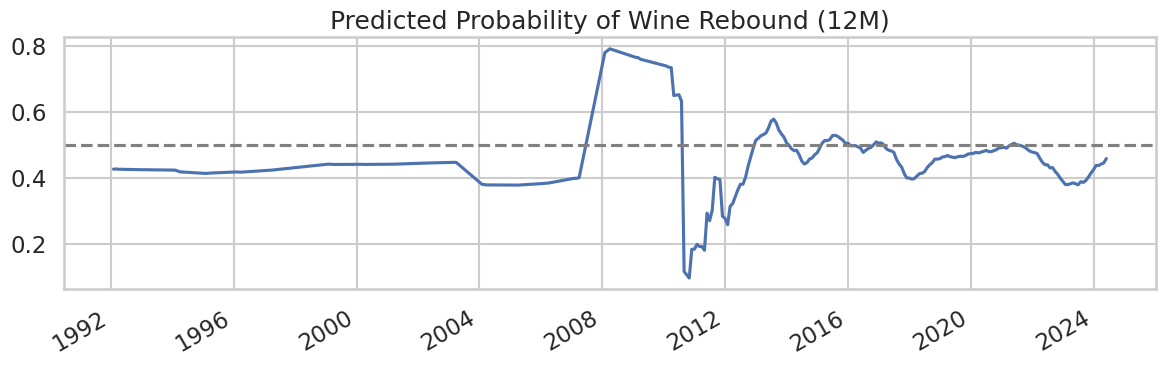

In [88]:
# Predict probabilities
df_model['prob_rebound'] = clf.predict_proba(X)[:, 1]

# Plot probability over time
df_model['prob_rebound'].plot(figsize=(12, 4), title='Predicted Probability of Wine Rebound (12M)')
plt.axhline(0.5, linestyle='--', color='gray')
plt.grid(True)
plt.tight_layout()
plt.show()


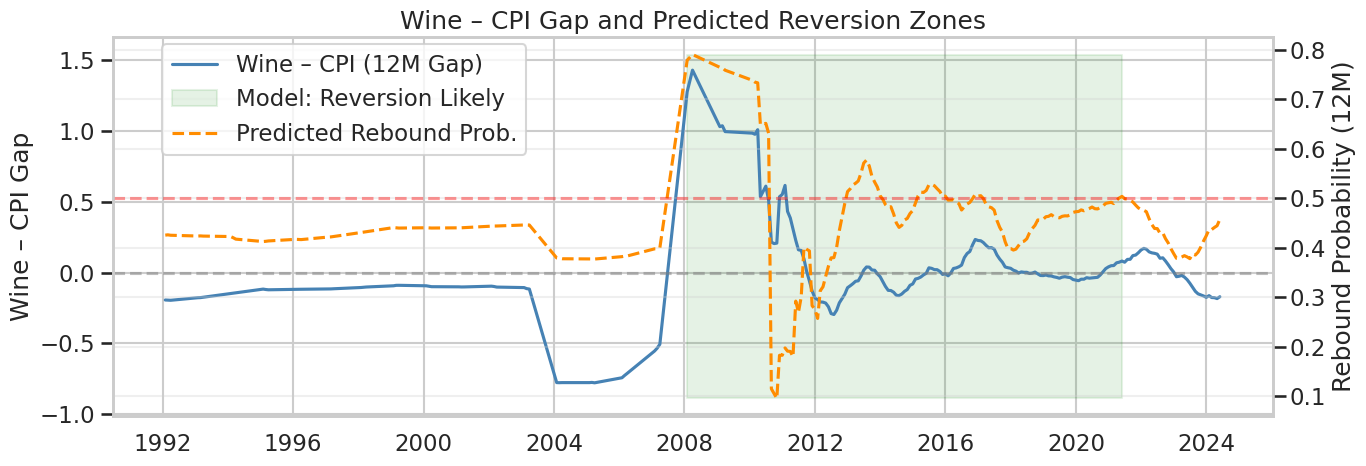

In [89]:
import matplotlib.pyplot as plt

# Assumes df_model already has:
# - wine_minus_cpi (gap)
# - prob_rebound (from classifier)
# - wine_ret_next_12m (actual future return)

# Create figure
fig, ax1 = plt.subplots(figsize=(14, 5))

# Plot wine - CPI gap
ax1.plot(df_model.index, df_model['wine_minus_cpi'], label='Wine – CPI (12M Gap)', color='steelblue')
ax1.set_ylabel('Wine – CPI Gap')
ax1.axhline(0, linestyle='--', color='gray', alpha=0.5)

# Plot predicted rebound probability on secondary y-axis
ax2 = ax1.twinx()
ax2.plot(df_model.index, df_model['prob_rebound'], label='Predicted Rebound Prob.', color='darkorange', linestyle='--')
ax2.axhline(0.5, linestyle='--', color='red', alpha=0.4)
ax2.set_ylabel('Rebound Probability (12M)')

# Highlight areas where rebound probability > 0.5
high_prob = df_model[df_model['prob_rebound'] > 0.5]
ax1.fill_between(high_prob.index, ax1.get_ylim()[0], ax1.get_ylim()[1],
                 color='green', alpha=0.1, label='Model: Reversion Likely')

# Titles and legends
plt.title('Wine – CPI Gap and Predicted Reversion Zones')
fig.legend(loc='upper left', bbox_to_anchor=(0.12, 0.9))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [94]:
# Parameters
gap_threshold = 0.05  # 5% divergence

# Identify divergence points (gap > +5% or < -5%)
df_model['diverged'] = (df_model['wine_minus_cpi'].abs() > gap_threshold).astype(int)

# Create a flag when the gap returns below threshold after diverging
df_model['reverted'] = 0
diverged = False

for i in range(1, len(df_model)):
    if not diverged and df_model['diverged'].iloc[i] == 1:
        diverged = True
        df_model.at[df_model.index[i], 'diverge_start'] = 1
    elif diverged and df_model['diverged'].iloc[i] == 0:
        diverged = False
        df_model.at[df_model.index[i], 'reverted'] = 1

df_model['diverge_start'] = df_model['diverge_start'].fillna(0)


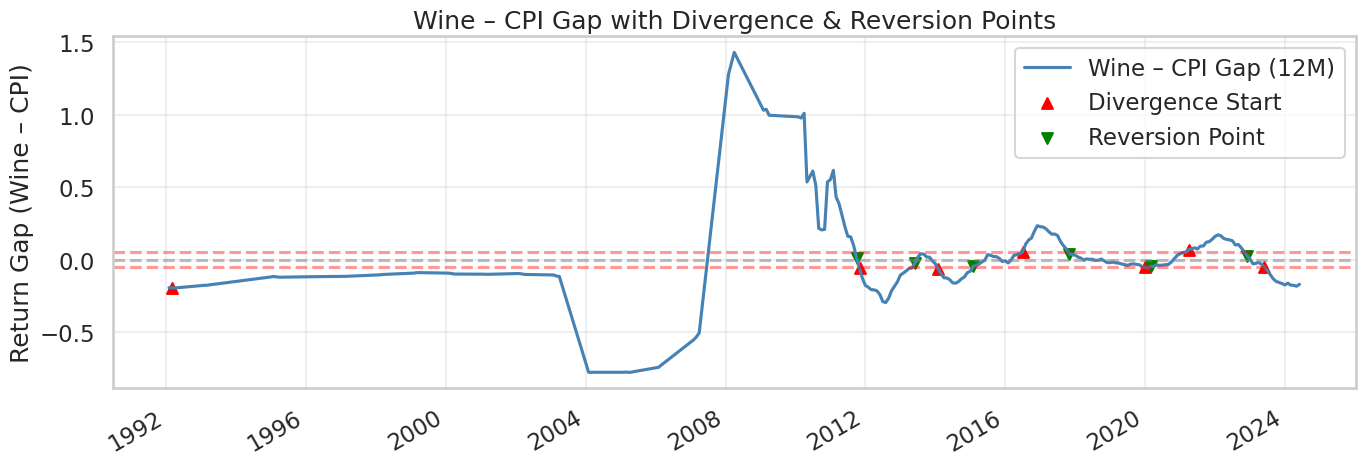

In [95]:
fig, ax = plt.subplots(figsize=(14, 5))

# Plot gap
df_model['wine_minus_cpi'].plot(ax=ax, color='steelblue', label='Wine – CPI Gap (12M)')
ax.axhline(0, linestyle='--', color='gray', alpha=0.5)
ax.axhline(gap_threshold, linestyle='--', color='red', alpha=0.4)
ax.axhline(-gap_threshold, linestyle='--', color='red', alpha=0.4)

# Mark divergence points
div_start = df_model[df_model['diverge_start'] == 1]
revert_pts = df_model[df_model['reverted'] == 1]

ax.scatter(div_start.index, div_start['wine_minus_cpi'], color='red', label='Divergence Start', marker='^', s=60)
ax.scatter(revert_pts.index, revert_pts['wine_minus_cpi'], color='green', label='Reversion Point', marker='v', s=60)

plt.title('Wine – CPI Gap with Divergence & Reversion Points')
plt.ylabel('Return Gap (Wine – CPI)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


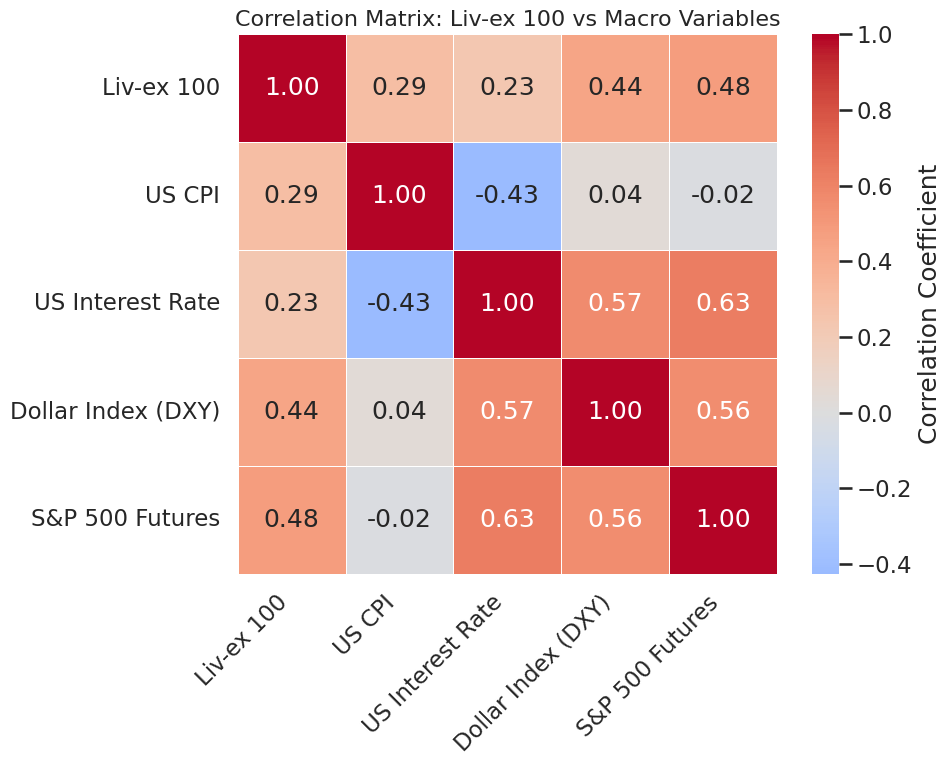

In [47]:
# Correlation matrix of selected macro variables
macro_cols = ['Liv-ex 100', 'US CPI', 'US Interest Rate', 'Dollar Index (DXY)', 'Gold', 'S&P 500 Futures']
available = [col for col in macro_cols if col in df.columns]
corr_matrix = df[available].dropna().corr()

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
            fmt=".2f", square=True, linewidths=.5, cbar_kws={'label': 'Correlation Coefficient'})
plt.title("Correlation Matrix: Liv-ex 100 vs Macro Variables", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


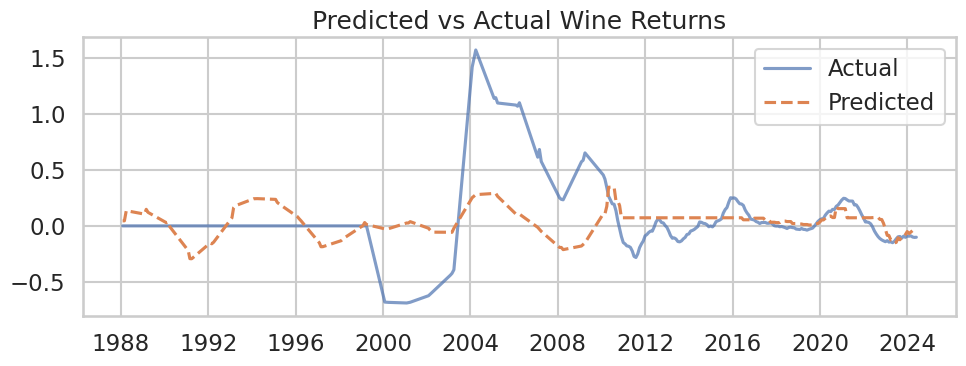

In [71]:
y_pred = model.predict(X)
plt.figure(figsize=(10, 4))
plt.plot(y.index, y, label='Actual', alpha=0.7)
plt.plot(y.index, y_pred, label='Predicted', linestyle='--')
plt.legend()
plt.title('Predicted vs Actual Wine Returns')
plt.grid(True)
plt.tight_layout()
plt.show()


In [74]:
# Filter from 2003 onward
df_filtered = df[['Liv-ex 100', 'US Interest Rate']].loc['2003':].dropna()


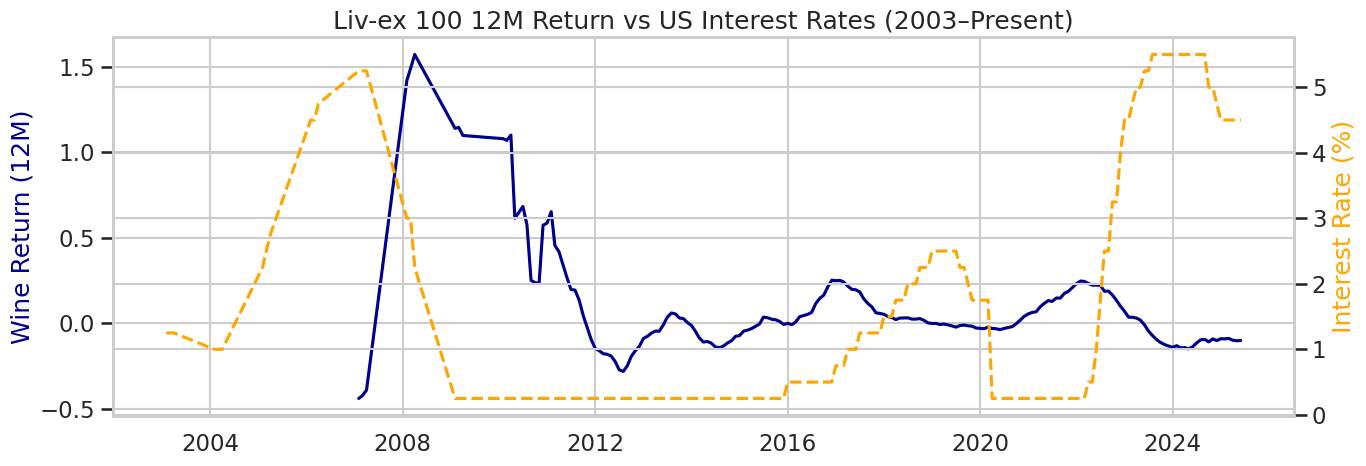

🔍 Linear Regression Results
R²: 0.18942845168043654
Rate_lag_0: -0.0944
Rate_lag_3: 0.0700
Rate_lag_6: 0.0082
Rate_lag_12: 0.0277


/tmp/ipython-input-79-1721927290.py:56: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_lagged.groupby('rate_regime')['wine_12m_ret'].mean().plot(kind='bar', color='steelblue')


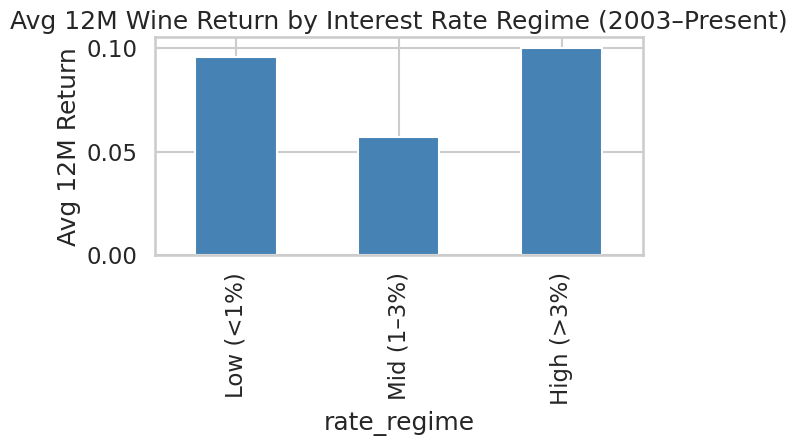

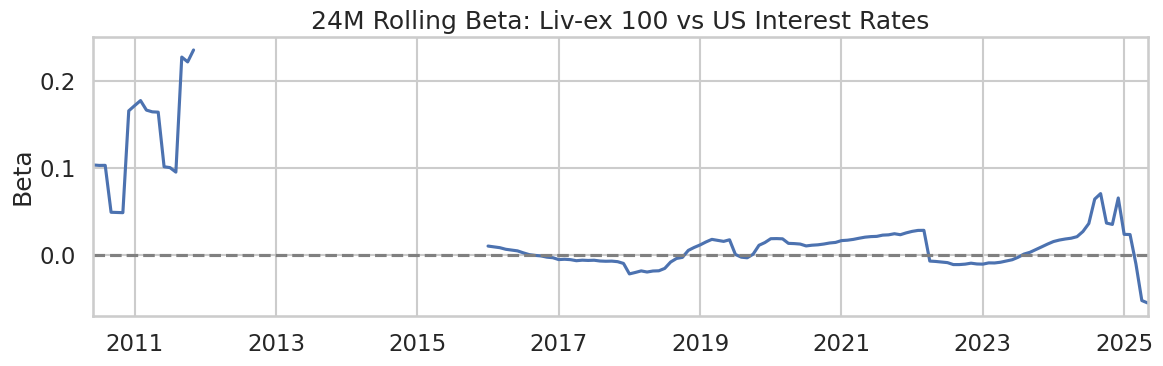

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# -----------------------------
# 1. Filter data from 2003 onward
# -----------------------------
df_filtered = df[['Liv-ex 100', 'US Interest Rate']].loc['2003':].dropna()

# -----------------------------
# 2. Visual overlay: 12M wine return vs interest rates
# -----------------------------
df_filtered['wine_12m_ret'] = df_filtered['Liv-ex 100'].pct_change(12)

fig, ax1 = plt.subplots(figsize=(14, 5))
ax1.plot(df_filtered.index, df_filtered['wine_12m_ret'], label='12M Wine Return', color='darkblue')
ax1.set_ylabel('Wine Return (12M)', color='darkblue')

ax2 = ax1.twinx()
ax2.plot(df_filtered.index, df_filtered['US Interest Rate'], label='US Interest Rate', color='orange', linestyle='--')
ax2.set_ylabel('Interest Rate (%)', color='orange')

plt.title('Liv-ex 100 12M Return vs US Interest Rates (2003–Present)')
fig.tight_layout()
plt.grid(True)
plt.show()

# -----------------------------
# 3. Lagged regression: interest rate lags vs future wine return
# -----------------------------
df_lagged = df_filtered[['Liv-ex 100', 'US Interest Rate']].copy()
for lag in [0, 3, 6, 12]:
    df_lagged[f'Rate_lag_{lag}'] = df_lagged['US Interest Rate'].shift(lag)

df_lagged['wine_12m_ret'] = df_lagged['Liv-ex 100'].pct_change(12).shift(-12)

features = [f'Rate_lag_{lag}' for lag in [0, 3, 6, 12]]
model_data = df_lagged[features + ['wine_12m_ret']].dropna()
X = model_data[features]
y = model_data['wine_12m_ret']

model = LinearRegression().fit(X, y)
print("🔍 Linear Regression Results")
print("R²:", model.score(X, y))
for name, coef in zip(X.columns, model.coef_):
    print(f"{name}: {coef:.4f}")

# -----------------------------
# 4. Bar chart: wine return by rate regime
# -----------------------------
df_lagged['rate_regime'] = pd.cut(df_lagged['US Interest Rate'],
                                  bins=[-1, 1, 3, 10],
                                  labels=['Low (<1%)', 'Mid (1–3%)', 'High (>3%)'])

df_lagged.groupby('rate_regime')['wine_12m_ret'].mean().plot(kind='bar', color='steelblue')
plt.title('Avg 12M Wine Return by Interest Rate Regime (2003–Present)')
plt.ylabel('Avg 12M Return')
plt.grid(True)
plt.tight_layout()
plt.show()

# -----------------------------
# 5. Rolling 24-month beta: Liv-ex 100 vs US Interest Rates
# -----------------------------
def rolling_beta(series1, series2, window=24):
    betas = []
    for i in range(window, len(series1)):
        x = series2.iloc[i-window:i]
        y = series1.iloc[i-window:i]
        if x.std() == 0 or np.isnan(x).any() or np.isnan(y).any():
            betas.append(np.nan)
        else:
            cov = np.cov(x, y)[0, 1]
            var = np.var(x)
            betas.append(cov / var)
    return pd.Series(betas, index=series1.index[window:])

# Monthly returns
returns = df_filtered[['Liv-ex 100', 'US Interest Rate']].pct_change().dropna()

# Compute rolling beta
beta_series = rolling_beta(returns['Liv-ex 100'], returns['US Interest Rate'], window=24)

# Plot
beta_series.plot(figsize=(12, 4), title='24M Rolling Beta: Liv-ex 100 vs US Interest Rates')
plt.axhline(0, linestyle='--', color='gray')
plt.ylabel('Beta')
plt.grid(True)
plt.tight_layout()
plt.show()


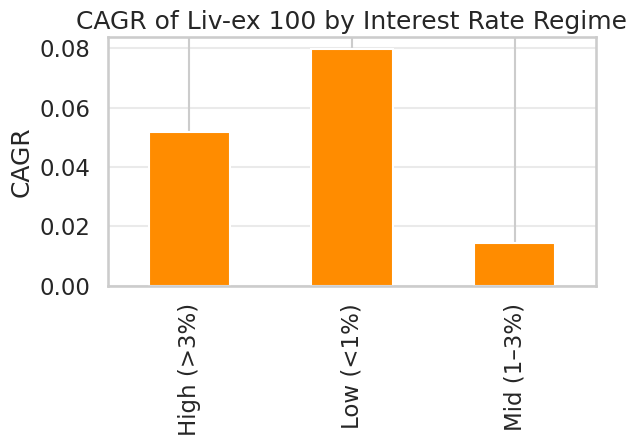

In [81]:
# Step 1: Prepare the data
df_cagr = df[['Liv-ex 100', 'US Interest Rate']].copy().loc['2003':].dropna()

# Step 2: Classify interest rate regimes
df_cagr['rate_regime'] = pd.cut(
    df_cagr['US Interest Rate'],
    bins=[-1, 1, 3, 10],
    labels=['Low (<1%)', 'Mid (1–3%)', 'High (>3%)']
)

# Step 3: Calculate CAGR for each regime
cagr_results = {}

for regime in df_cagr['rate_regime'].unique():
    regime_df = df_cagr[df_cagr['rate_regime'] == regime]
    if regime_df.empty:
        continue
    start_value = regime_df['Liv-ex 100'].iloc[0]
    end_value = regime_df['Liv-ex 100'].iloc[-1]
    n_years = (regime_df.index[-1] - regime_df.index[0]).days / 365.25

    if start_value > 0 and n_years > 0:
        cagr = (end_value / start_value) ** (1 / n_years) - 1
        cagr_results[regime] = cagr

# Step 4: Display as bar chart
pd.Series(cagr_results).sort_index().plot(kind='bar', color='darkorange')
plt.title('CAGR of Liv-ex 100 by Interest Rate Regime')
plt.ylabel('CAGR')
plt.grid(True, axis='y', alpha=0.4)
plt.tight_layout()
plt.show()


✅ Random Forest Results
Test R²: 0.1639
RMSE: 0.1179


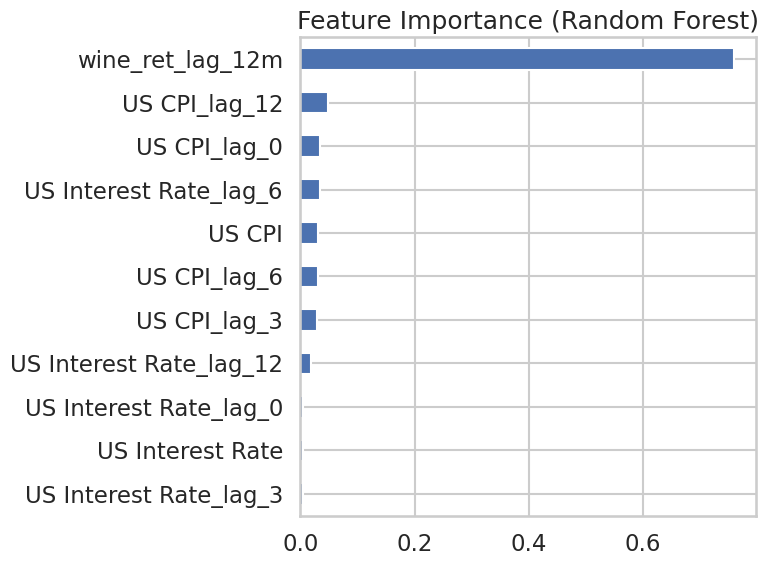

In [97]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

# -----------------------------
# Step 1: Set up macro indicators
# -----------------------------
macro_cols = ['Liv-ex 100', 'US CPI', 'US Interest Rate', 'TVC_DXY, 1M']
existing_cols = [col for col in macro_cols if col in df.columns]

df_rf = df[existing_cols].copy().dropna()

# -----------------------------
# Step 2: Lagged macro features
# -----------------------------
for col in ['US CPI', 'US Interest Rate', 'TVC_DXY, 1M']:
    if col in df_rf.columns:
        for lag in [0, 3, 6, 12]:
            df_rf[f'{col}_lag_{lag}'] = df_rf[col].shift(lag)

# Lagged wine return
df_rf['wine_ret_lag_12m'] = df_rf['Liv-ex 100'].pct_change(12).shift(0)

# -----------------------------
# Step 3: Target: future wine return
# -----------------------------
df_rf['wine_ret_next_12m'] = df_rf['Liv-ex 100'].pct_change(12).shift(-12)

# Drop NaNs
df_rf = df_rf.dropna()

# -----------------------------
# Step 4: Prepare model inputs
# -----------------------------
features = [col for col in df_rf.columns if col not in ['Liv-ex 100', 'wine_ret_next_12m']]
X = df_rf[features]
y = df_rf['wine_ret_next_12m']

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.25)

# -----------------------------
# Step 5: Train Random Forest
# -----------------------------
rf = RandomForestRegressor(n_estimators=500, max_depth=4, random_state=42)
rf.fit(X_train, y_train)

# Predict & evaluate
y_pred = rf.predict(X_test)
print("✅ Random Forest Results")
print("Test R²:", round(r2_score(y_test, y_pred), 4))
print("RMSE:", round(np.sqrt(mean_squared_error(y_test, y_pred)), 4))

# -----------------------------
# Step 6: Feature Importance
# -----------------------------
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=True)
importances.plot(kind='barh', figsize=(8, 6), title='Feature Importance (Random Forest)')
plt.tight_layout()
plt.show()


In [99]:
# Calculate rolling 12-month return (momentum)
df['wine_12m_ret'] = df['Liv-ex 100'].pct_change(12)

# Cumulative price for drawdown calc
df['cum_price'] = df['Liv-ex 100']
df['rolling_max'] = df['cum_price'].cummax()
df['drawdown'] = df['cum_price'] / df['rolling_max'] - 1


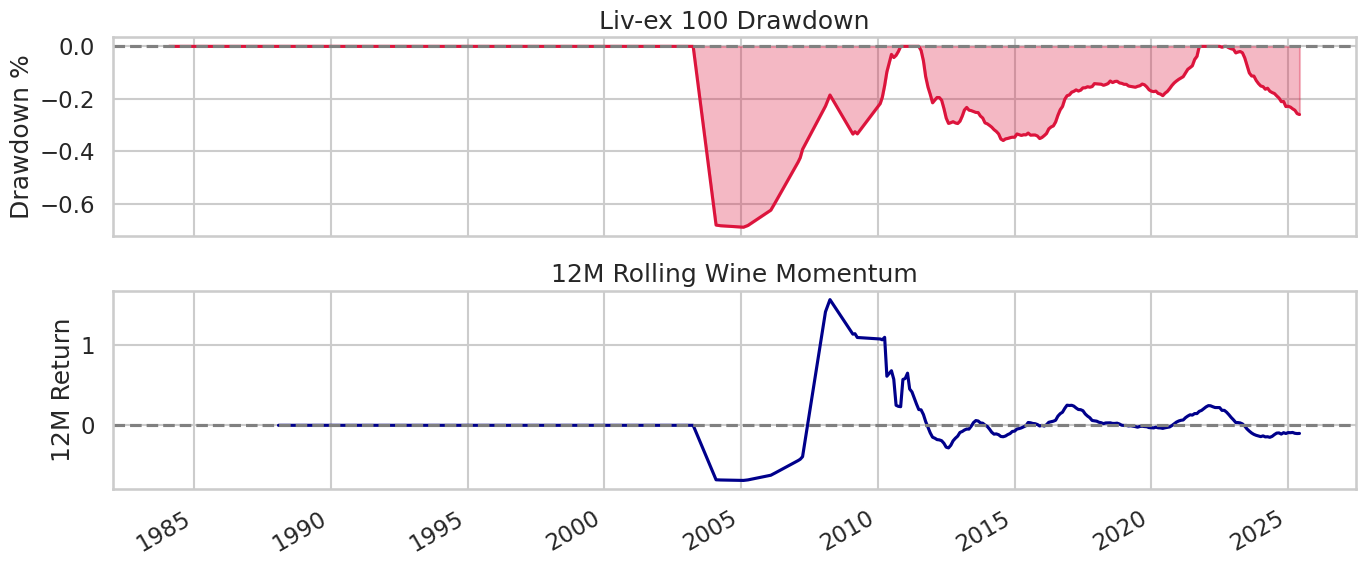

In [100]:
fig, ax = plt.subplots(2, 1, figsize=(14, 6), sharex=True)

df['drawdown'].plot(ax=ax[0], color='crimson', title='Liv-ex 100 Drawdown')
ax[0].fill_between(df.index, df['drawdown'], color='crimson', alpha=0.3)
ax[0].set_ylabel('Drawdown %')
ax[0].axhline(0, linestyle='--', color='gray')

df['wine_12m_ret'].plot(ax=ax[1], color='darkblue', title='12M Rolling Wine Momentum')
ax[1].axhline(0, linestyle='--', color='gray')
ax[1].set_ylabel('12M Return')

plt.tight_layout()
plt.show()


In [102]:
df['momentum_now'] = df['wine_12m_ret']
df['momentum_next'] = df['wine_12m_ret'].shift(-6)  # 6-month future momentum
df['momentum_direction_change'] = np.sign(df['momentum_next']) != np.sign(df['momentum_now'])


In [105]:
# --- Step 0: Setup features ---
df['wine_12m_ret'] = df['Liv-ex 100'].pct_change(12)
df['wine_vol_12m'] = df['Liv-ex 100'].pct_change().rolling(12).std()

# Future momentum shift flag
df['momentum_next'] = df['wine_12m_ret'].shift(-6)
df['momentum_direction_change'] = np.sign(df['momentum_next']) != np.sign(df['wine_12m_ret'])

# Add any missing macro lags
if 'US CPI_lag_12' not in df.columns and 'US CPI' in df.columns:
    df['US CPI_lag_12'] = df['US CPI'].shift(12)

if 'US Interest Rate_lag_6' not in df.columns and 'US Interest Rate' in df.columns:
    df['US Interest Rate_lag_6'] = df['US Interest Rate'].shift(6)

# --- Step 1: Select features ---
features = [col for col in [
    'wine_12m_ret',
    'wine_vol_12m',
    'US CPI_lag_12',
    'US Interest Rate',
    'US Interest Rate_lag_6'
] if col in df.columns]

# --- Step 2: Prepare input & target ---
X = df[features].dropna()
y = df.loc[X.index, 'momentum_direction_change'].astype(int)

# --- Step 3: Train/test split & fit with class_weight ---
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.3)

clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=5,
    class_weight='balanced',  # <== key improvement
    random_state=42
)
clf.fit(X_train, y_train)

# --- Step 4: Evaluate ---
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

print("✅ Accuracy:", clf.score(X_test, y_test))
print(classification_report(y_test, y_pred))
print("ROC AUC:", round(roc_auc_score(y_test, y_proba), 4))


✅ Accuracy: 0.5466666666666666
              precision    recall  f1-score   support

           0       0.74      0.61      0.67        57
           1       0.21      0.33      0.26        18

    accuracy                           0.55        75
   macro avg       0.48      0.47      0.47        75
weighted avg       0.62      0.55      0.57        75

ROC AUC: 0.6199


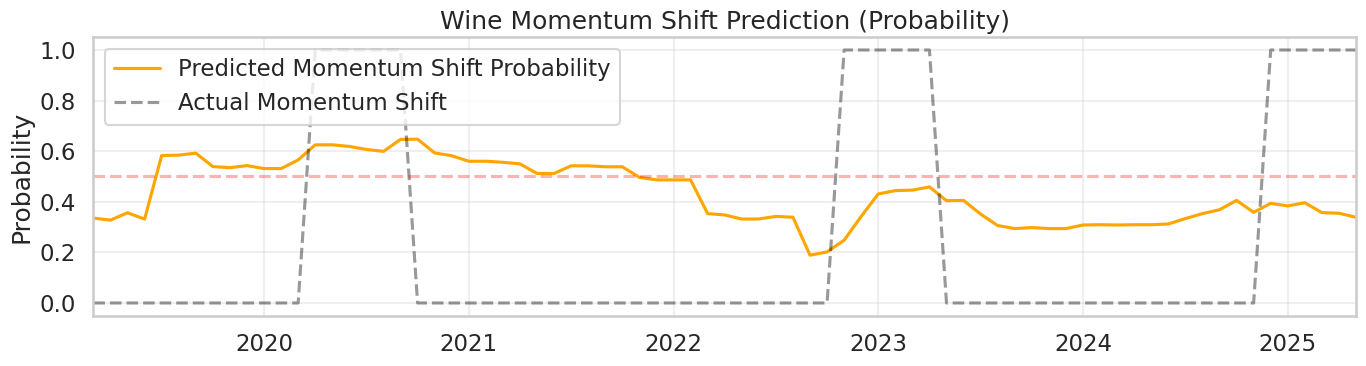

In [106]:
import matplotlib.pyplot as plt

# Save results to DataFrame for plotting
df_result = X_test.copy()
df_result['actual_shift'] = y_test
df_result['predicted_shift_prob'] = y_proba

# Plot
fig, ax = plt.subplots(figsize=(14, 4))
df_result['predicted_shift_prob'].plot(ax=ax, color='orange', label='Predicted Momentum Shift Probability')
df_result['actual_shift'].plot(ax=ax, color='black', alpha=0.4, linestyle='--', label='Actual Momentum Shift')
plt.axhline(0.5, linestyle='--', color='red', alpha=0.3)
plt.title("Wine Momentum Shift Prediction (Probability)")
plt.ylabel("Probability")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


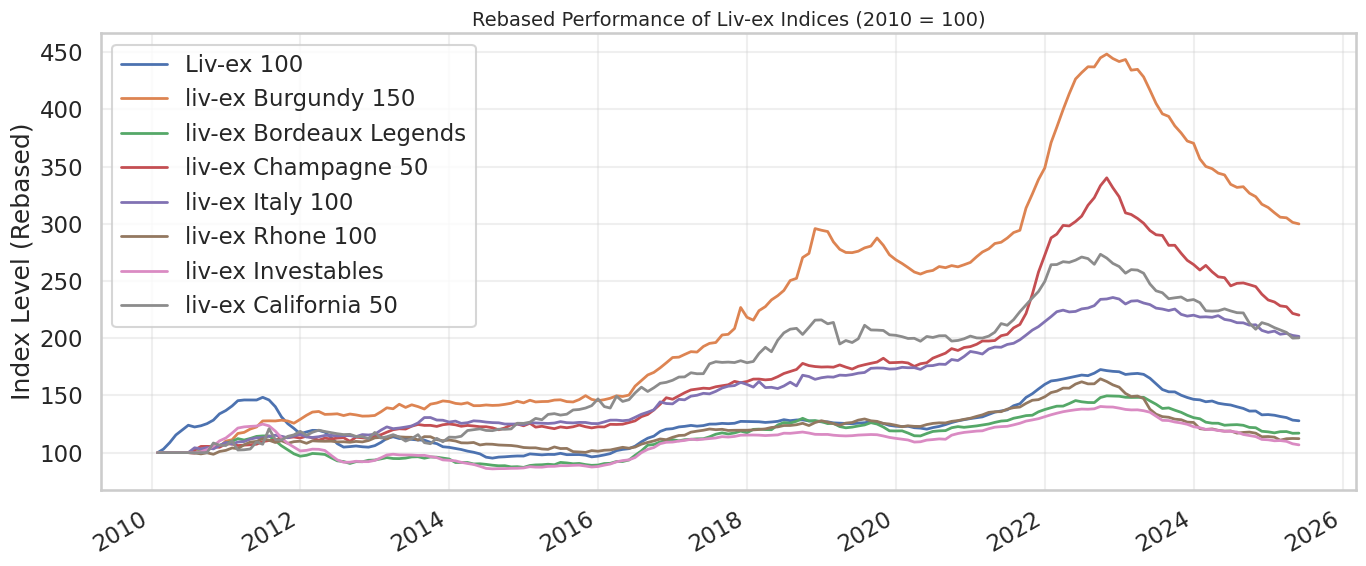

In [56]:
# Ensure index is datetime and sorted
df.index = pd.to_datetime(df.index)
df = df.sort_index()

# Choose wine indices
wine_indices = [
    'Liv-ex 100', 'liv-ex Burgundy 150', 'liv-ex Bordeaux Legends',
    'liv-ex Champagne 50', 'liv-ex Italy 100', 'liv-ex Rhone 100',
    'liv-ex Fine Wine 1000', 'liv-ex Investables', 'liv-ex California 50'
]

# Filter valid columns
valid_indices = [col for col in wine_indices if col in df.columns]

# Slice from 2010 onward (now safe)
rebased_df = df[valid_indices].loc['2010':].copy()

# Rebase to 100
rebased = rebased_df.div(rebased_df.iloc[0]).mul(100)

# Plot
rebased.plot(figsize=(14, 6), linewidth=2)
plt.title("Rebased Performance of Liv-ex Indices (2010 = 100)", fontsize=14)
plt.ylabel("Index Level (Rebased)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


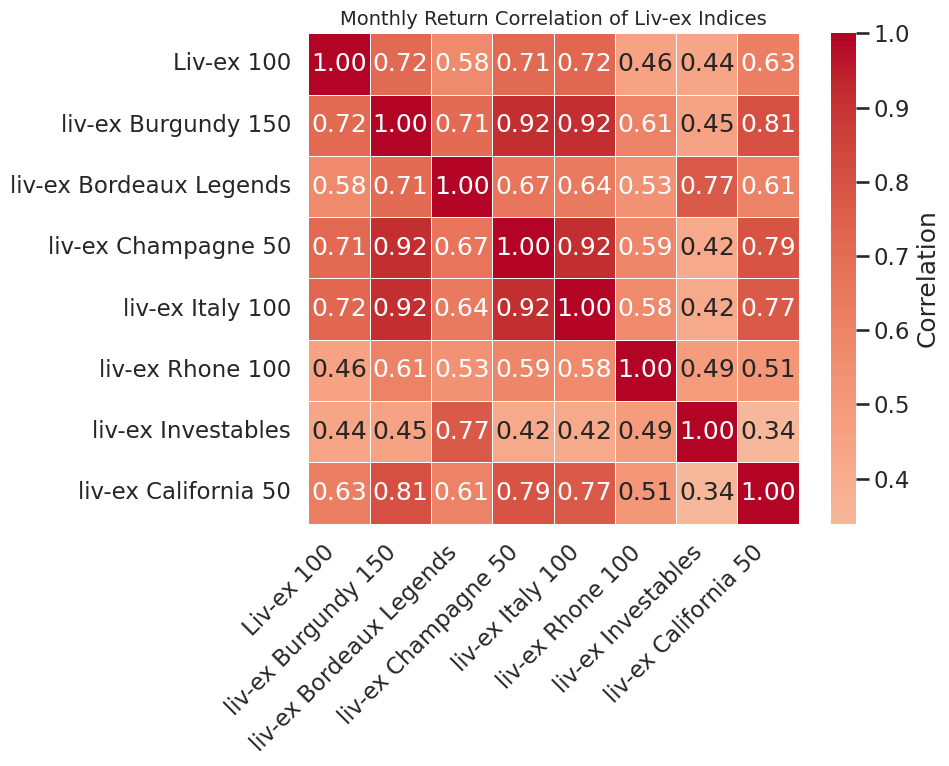

In [57]:
# Compute monthly returns
monthly_returns = df[valid_indices].pct_change().dropna()

# Compute correlation matrix
correlation_matrix = monthly_returns.corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0,
            linewidths=0.5, square=True, cbar_kws={'label': 'Correlation'})
plt.title("Monthly Return Correlation of Liv-ex Indices", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


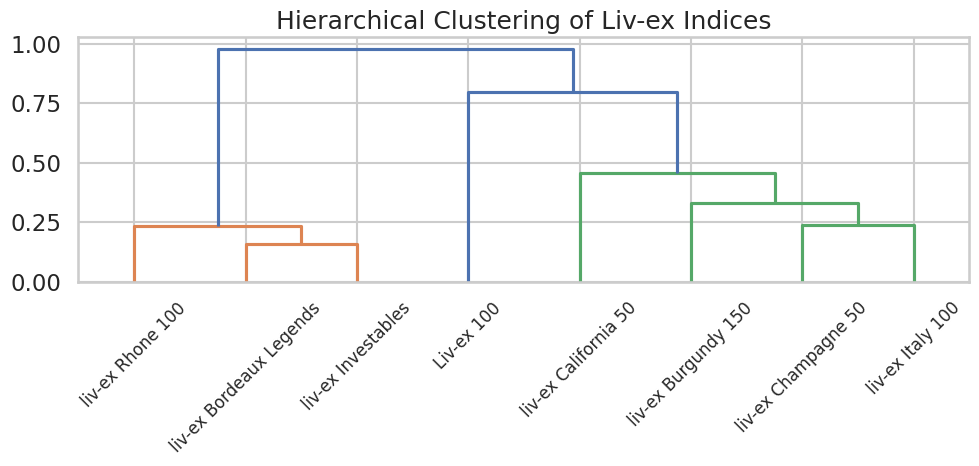

In [59]:
from scipy.cluster.hierarchy import linkage, dendrogram

# Compute correlation distance matrix
linked = linkage(monthly_returns.T, method='ward')

# Plot dendrogram
plt.figure(figsize=(10, 5))
dendrogram(linked, labels=monthly_returns.columns, leaf_rotation=45)
plt.title("Hierarchical Clustering of Liv-ex Indices")
plt.tight_layout()
plt.show()
